# Tutorial 1: Simulated data

## Welcome to Ocelli!

*Ocelli (singular Ocellus, Latin: little eye) – simple eyes found in many insects in triplets. Their function is to navigate insects during the day or to detect movement.*

Ocelli is an open-source Python library with computational tools for preprocessing, analyzing, and plotting multimodal single-cell developmental data. Ocelli's functionality includes the following:

- modeling multimodal developmental processes with Multimodal Diffusion Maps,
- reducing data dimensionality with ForceAtlas2 and UMAP,
- calculating z-scores of gene signatures,
- plotting 2D and interactive 3D plots.

Ocelli can be easily added to your familiar single-cell analysis pipelines thanks to being integrated with the AnnData data structure.

We prepared a series of tutorials introducing a spectrum of Ocelli’s functionality and applications. Ocelli is designed for analyzing multimodal data when each cell has entries from each modality. Firstly, we will work on simulated data to build intuition. We will then proceed to multimodal single-cell data from hair follicle and human bone marrow, including modalities such as RNA-seq, ATAC-seq, and proteins. Lastly, we will share a new perspective on exploring unimodal data based on pancreatic endocrinogenesis and cell reprogramming datasets.

After these tutorials, you should be able to:
    
- explore single-cell developmental multimodal data,
- understand the benefits of joint analysis and visualization of multimodal data,
- construct Multimodal Diffusion Maps embeddings of simulated and experimental data and visualize them using Ocelli.

## Simulated data I: Binary tree

Modality, in general, refers to an experimentally measured genome-wide feature. For example, RNA-seq is the transcriptome's single-cell modality, represented by a cell-by-gene count matrix encoding gene expression. The higher the value in the count matrix, the more expressed a gene is in a cell. However, a wide range of biological information is lost when analyzing only the transcriptome. A simplistic version of the *central dogma of molecular biology* states that *DNA makes RNA, and RNA makes protein*. As a result, when looking solely at RNA levels, you omit information hidden in DNA and protein. To understand biological processes at a molecular level, you must interpret multimodal, not unimodal information.

**Note**: This is the first tutorial, which introduces multimodal analysis based on simulated data. Analysis of single-cell data is discussed in subsequent tutorials.

Import Ocelli.

In [1]:
import ocelli as oci

We shortened the imported name to ``oci`` for better code readability. 
Ocelli has three modules: ``oci.pp`` (data preprocessing), ``oci.tl`` (analysis tools), and ``oci.pl`` (plotting).
The workflow typically consists of multiple calls on an ``anndata.AnnData`` object.

Some Ocelli functions include probabilistic steps. We set a random seed for the sake of reproducibility. If you omit this step, each run will result in marginally different outcomes, which is a natural effect in stochastic processes. Note that setting a seed may result in different outcomes when code is run on other processors.

In [2]:
SEED = 17

### Exploring single modalities

To build your intuition, we prepared simulated data, which should be easy to interpret. You can download it [here](LINK) and load as follows.

In [3]:
import anndata as ad
from os.path import join

# your local path to a folder with downloaded data
source_path = '../../../data/simulated_data_i'

adata = ad.read_h5ad(join(source_path, 'binary-tree-dataset.h5ad'))

adata

AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'type', 'pseudotime'
    uns: 'modalities'
    obsm: 'modality0', 'modality1', 'modality2'

Ocelli uses an annotated data structure called [AnnData](https://anndata.readthedocs.io). We recommend glancing at its linked documentation if you need to familiarize yourself with it. Here, we load an h5ad file storing an AnnData object with three modalities: ``modality0``, ``modality1``, and ``modality2`` saved in ``adata.obsm``. Each modality is an array with rows corresponding to observations and columns to features. Note that *i*-th row in all modalities corresponds to the same observation. Modalities have 6,000 3-dimensional observations for quick, intuitive visualizations that would be impossible for high-dimensional single-cell data.

In [4]:
adata.obsm['modality0'].shape, adata.obsm['modality1'].shape, 
adata.obsm['modality2'].shape

(6000, 3)

``adata.uns['modalities']`` specifies which ``adata.obsm`` arrays are modalities.

In [5]:
adata.uns['modalities']

array(['modality0', 'modality1', 'modality2'], dtype=object)

``adata.obs`` is a ``pandas.DataFrame`` with metadata for observations. Here, observations are grouped into six types A-F (``adata.obs['type']``) and are ordered along a developmental pseudotime (``adata.obs['pseudotime']``). ``adata.var``, analogically, stores metadata for variable features. However, for this dataset, you do not use it.

In [6]:
adata.obs

type  pseudotime
0       A           0
1       A           1
2       A           2
3       A           3
4       A           4
...   ...         ...
5995    F        2995
5996    F        2996
5997    F        2997
5998    F        2998
5999    F        2999

[6000 rows x 2 columns]

First, prepare a observation type to color assignment for plotting purposes.

In [7]:
cdict = {'A': '#1a62a5',
         'B': '#a0bae2',
         'C': '#fd6910', 
         'D': '#fdac65', 
         'E': '#289322', 
         'F': '#89db77'}

Ocelli can produce static scatter plots using [Matplotlib](https://matplotlib.org) or interactive plots using [Plotly](https://plotly.com/python/). The presented tutorials will show only static plots due to the compatibility issues between interactive plots and online documentation.

You can visualize each of the 3D modalities in two ways:

1) as a 3D interactive plot,

In [8]:
#oci.pl.scatter_interactive(adata, x='modality0', c='type', markersize=2, 
#cdiscrete=cdict, showaxes=True)

2) as a 2D projection. For projecting 3D data onto 2D planes, you can use Ocelli's `oci.pl.projection` function. It projects 3D data onto planes defined by their normal vectors (vectors perpendicular to the plane) oriented using polar coordinates `phi` (range: 0-360 degrees) and `theta` (range: 0-180 degrees).

For quick help choosing angles, use `oci.pl.projections`.

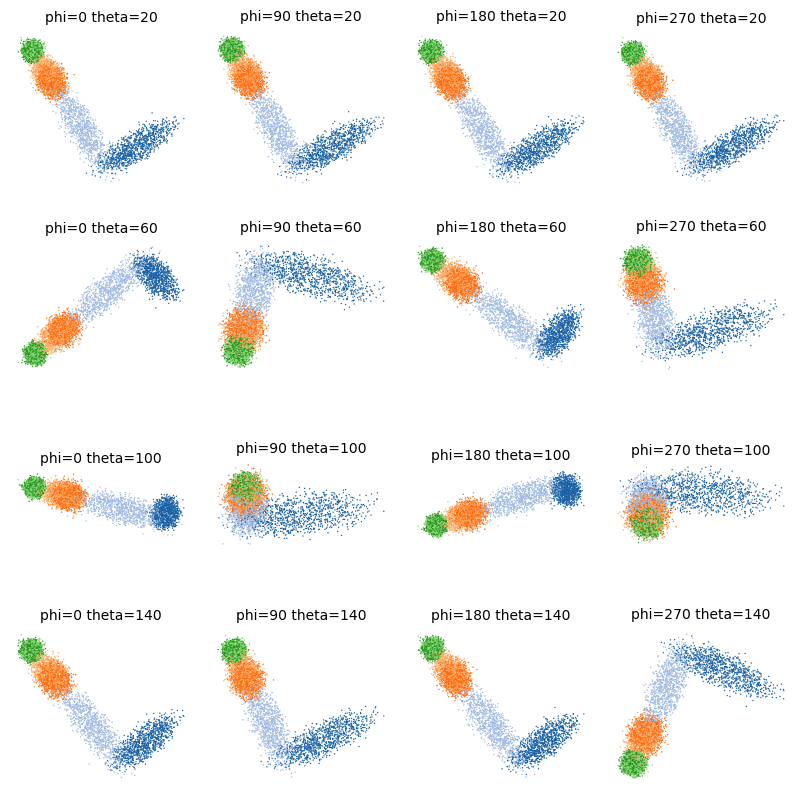

In [9]:
oci.pl.projections(adata, x='modality0', c='type', phis=[0, 90, 180, 270],
                   thetas=[20, 60, 100, 140], cdict=cdict, markersize=1, fontsize=10,
                   figsize=(8, 8), showlegend=False, random_state=SEED)

Select a projection: `phi=90` and `theta=20`.

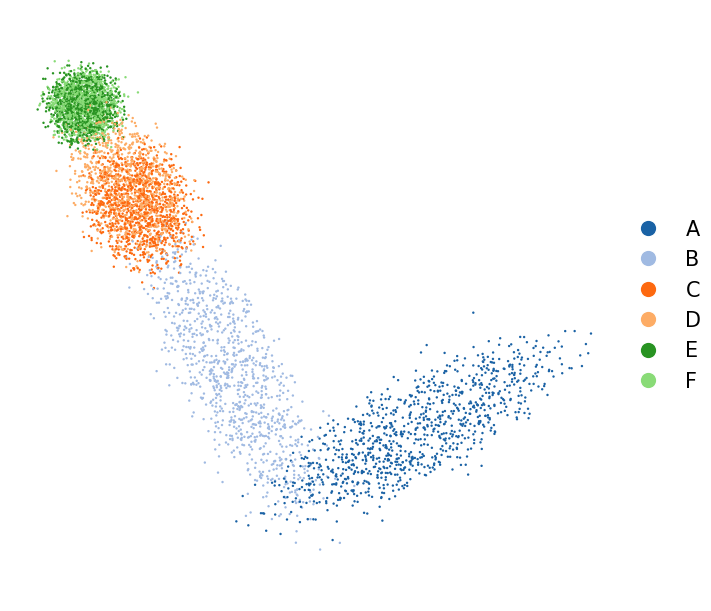

In [10]:
oci.tl.projection(adata, x='modality0', phi=90, theta=20, random_state=SEED)
# oci.tl.projection saves the projection by default to adata.obsm['X_proj']

oci.pl.scatter(adata, x='X_proj', c='type', cdict=cdict, markersize=3, markerscale=2,
               fontsize=15, figsize=(7, 6), title='')

In this dataset, observations form half of a binary tree with three branching points - each visible in a separate modality. `modality0` splits apart types A and B, while types C, D, and E, F are mixed up. When looking only at ``modality0``, it is impossible to understand the structure of the underlying developmental process beyond A and B observations.

Observations are ordered along a ``pseudotime``. The developmental process begins at the branching point of types A and B and proceeds further. 

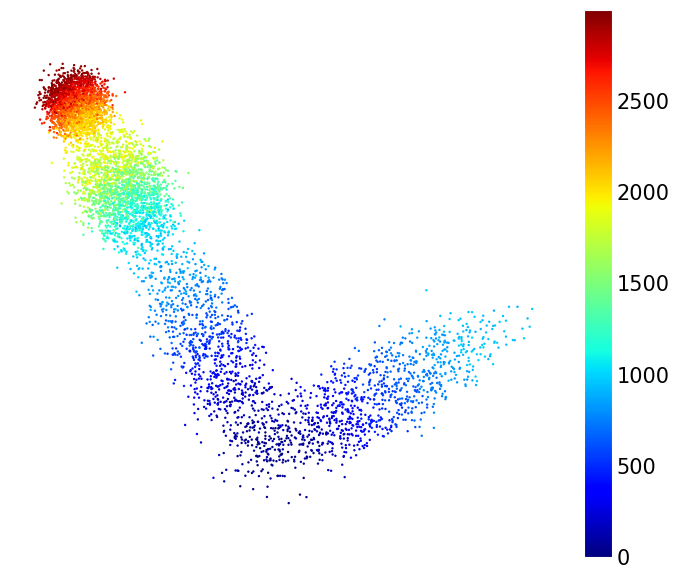

In [11]:
oci.pl.scatter(adata, x='X_proj', c='pseudotime', cmap='jet', markersize=3, 
               markerscale=2, fontsize=15, figsize=(7, 6), title='')

Repeat the same steps for `modality1`.

Look at `modality1` from different angles.

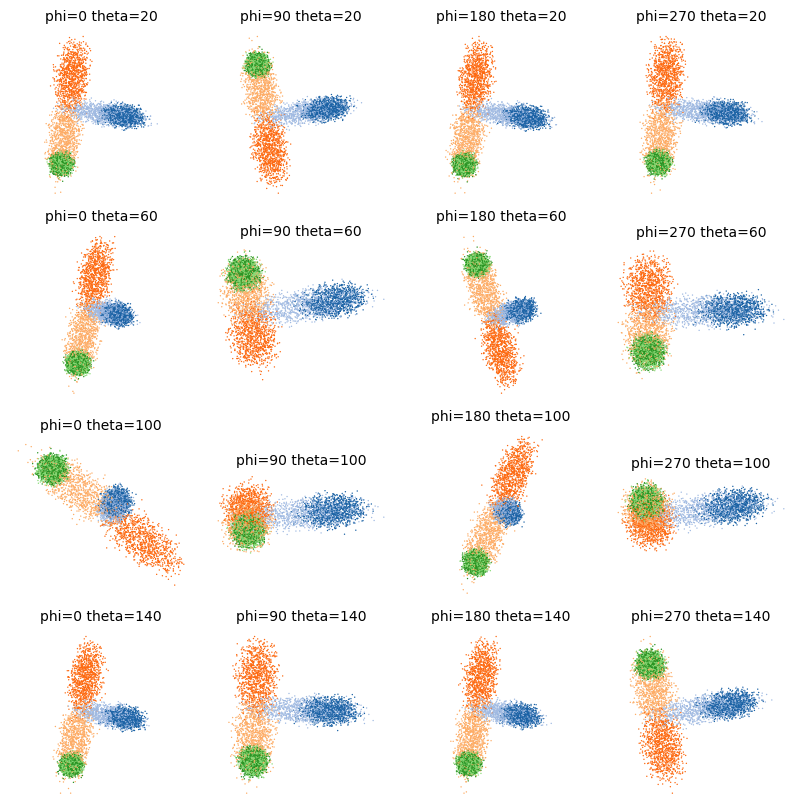

In [12]:
oci.pl.projections(adata, x='modality1', c='type', phis=[0, 90, 180, 270],
                   thetas=[20, 60, 100, 140], cdict=cdict, markersize=1, fontsize=10,
                   figsize=(8, 8), showlegend=False, random_state=SEED)

Select a projection.

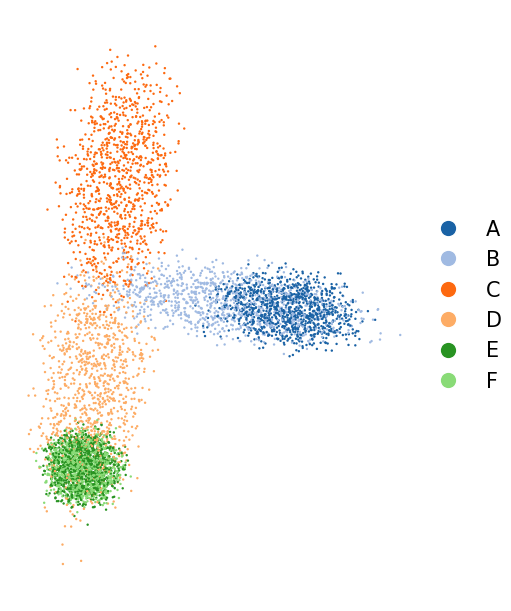

In [13]:
oci.tl.projection(adata, x='modality1', phi=0, theta=20, random_state=SEED)
oci.pl.scatter(adata, x='X_proj', c='type', markersize=3, markerscale=2, cdict=cdict, 
               fontsize=15, figsize=(5, 6), title='')

``modality1`` allows us to uncover lineages of types C and D, indistinguishable in ``modality0``.

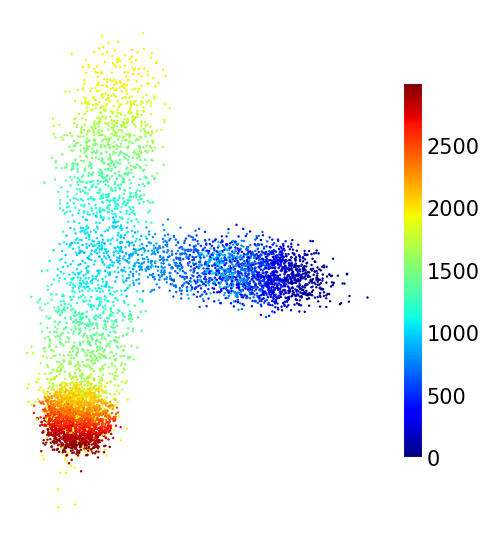

In [14]:
oci.pl.scatter(adata, x='X_proj', c='pseudotime', cmap='jet', markersize=3, 
               markerscale=2, fontsize=15, figsize=(5, 6), title='')

Similarly, ``modality2`` reveals types E and F as separate lineages, unseen when looking at ``modality0`` or ``modality1``.

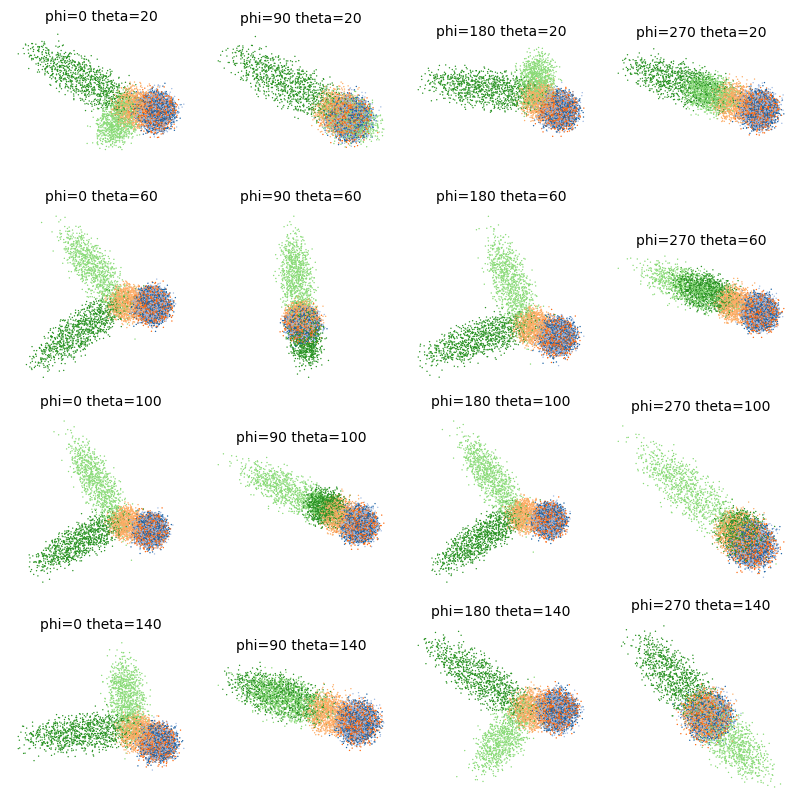

In [15]:
oci.pl.projections(adata, x='modality2', c='type', phis=[0, 90, 180, 270], 
                   thetas=[20, 60, 100, 140], cdict=cdict, markersize=1, fontsize=10,
                   figsize=(8, 8), showlegend=False, random_state=SEED)

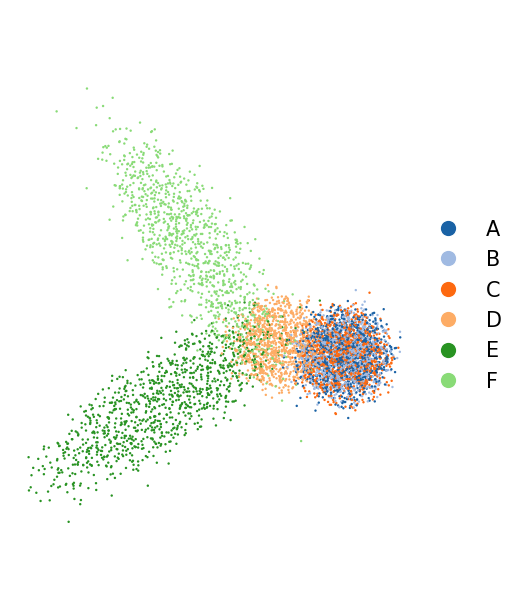

In [16]:
oci.tl.projection(adata, x='modality2', phi=180, theta=100, random_state=SEED)
oci.pl.scatter(adata, x='X_proj', c='type', markersize=3, markerscale=2, cdict=cdict, 
               fontsize=15, figsize=(5, 6), title='')

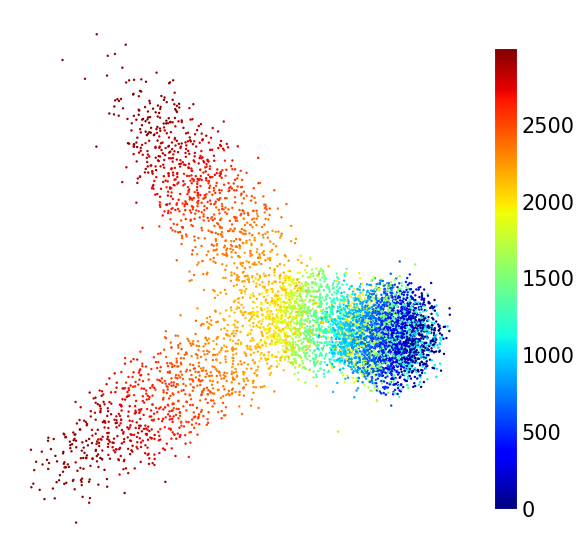

In [17]:
oci.pl.scatter(adata, x='X_proj', c='pseudotime', markersize=3, markerscale=2, 
               cmap='jet', fontsize=15, figsize=(6, 6), title='')

### Multimodal Diffusion Maps (MDM)

All the plots so far are unimodal - they do not visualize all levels of available information. Multimodal Diffusion Maps (MDM) is an algorithm for embedding multimodal data into a joint latent space. Using MDM can be split into three stages.

1. Finding observations' nearest neighbors in the feature space across all modalities.

In [18]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.


2. Calculating multimodal weights for each observation.

Multimodal weights form a distribution over modalities; each observation's weights sum to 1. A higher weight indicates that the algorithm selected the modality as more informative about observation and its neighborhood than others.

In [19]:
oci.tl.weights(adata, random_state=SEED, verbose=True)

2023-01-22 23:22:59,057	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


3. Calculating MDM embedding.

The parameter `n_components` defines the dimensionality of the MDM embedding. A good practice is to explore different values for each dataset individually. MDM components are information-rich, but their quality can degrade with quantity.

*Technical remark: below, we set `unimodal_norm` to `False`. We use its default `True` value for single-cell data. `unimodal_norm`'s value is changed here because the simulated 3D data is sampled from an artificial distribution, which is low-dimensional, dense, and not normalized. Single-cell data come from high-dimensional latent spaces of incomparable complexity that are properly normalized during data preprocessing (details in the following tutorials).*

In [20]:
oci.tl.MDM(adata, n_components=10, unimodal_norm=False, random_state=SEED, verbose=True)

2023-01-22 23:23:08,014	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


The resulting 10-dimensional MDM embedding represents a multimodal latent space from which the modeled developmental process originates. The embedding is saved to `adata.obsm['X_mdm']`.

### Visualizing MDM components

You can visualize the MDM embedding using ForceAtlas2, a force-directed layout (FLE) algorithm for graph visualization. This procedure takes three steps:

- finding nearest neighbors in the MDM latent space,
- computing the nearest neighbor graph,
- calculating the FLE graph representation.

In [21]:
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=30, verbose=True)
oci.tl.neighbors_graph(adata, x='X_mdm', n_edges=30, verbose=True)
oci.tl.FA2(adata, n_components=2, n_iter=5000, random_state=SEED)

[X_mdm]	30 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Jan 22, 2023 11:23:26 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 22, 2023 11:23:28 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 6,000 (6,000 added)
Jan 22, 2023 11:23:28 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 180,000 (108,678 added)


*************************25%
*************************50%
*************************75%
******************

*******100%
Time = 32.56s


In the MDM latent space, all observation types A-F are separated with well-defined branching points. It is easy to trace all developmental lineages, which were impossible to spot together in unimodal exploration.

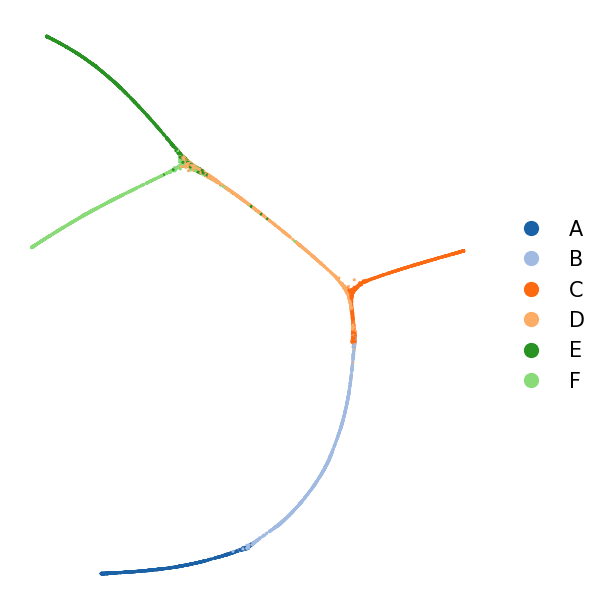

In [22]:
oci.pl.scatter(adata, x='X_fa2', c='type', cdict=cdict, markersize=5, markerscale=2,
               fontsize=15, figsize=(6,6), title='')

Moreover, the MDM representation preserves developmental pseudotime.

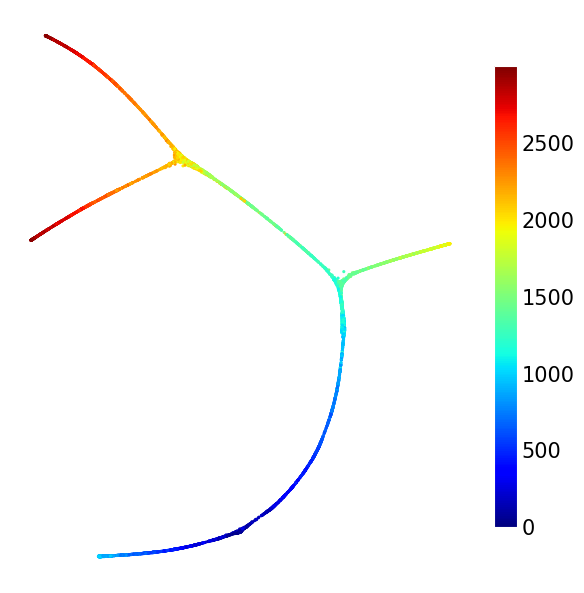

In [23]:
oci.pl.scatter(adata, x='X_fa2', c='pseudotime', cmap='jet', markersize=5, fontsize=15, 
               figsize=(6,6), title='')

Alternatively, you can use UMAP or any other dimension reduction algorithm to visualize the MDM embedding. Ocelli has built-in wrappers for ForceAtlas2 and UMAP. For well-connected data, we recommend ForceAtlas2, and for data with separate clusters, UMAP.

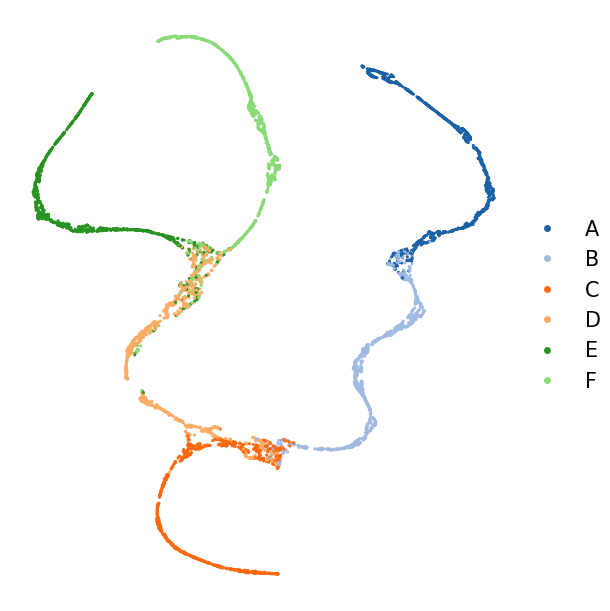

In [24]:
oci.tl.UMAP(adata, x='X_mdm', n_components=2, n_neighbors=20, min_dist=0.1, 
            random_state=SEED)

oci.pl.scatter(adata, x='X_umap', c='type', cdict=cdict, markersize=5, fontsize=15, 
               figsize=(6,6), title='')

### Interpreting multimodal weights

Calculated multimodal weights provide an explainable insight into the MDM's training. They are saved to ``adata.obsm['weights']``.

In [25]:
adata.obsm['weights']

modality0  modality1  modality2
0      0.973592   0.025576   0.000832
1      0.989186   0.008797   0.002017
2      0.992478   0.006181   0.001341
3      0.967995   0.030422   0.001583
4      0.993608   0.004865   0.001527
...         ...        ...        ...
5995   0.000107   0.000101   0.999793
5996   0.000115   0.000101   0.999784
5997   0.000117   0.000101   0.999782
5998   0.000159   0.000095   0.999746
5999   0.000148   0.000108   0.999744

[6000 rows x 3 columns]

You can examine the weight distribution concerning each observation type.

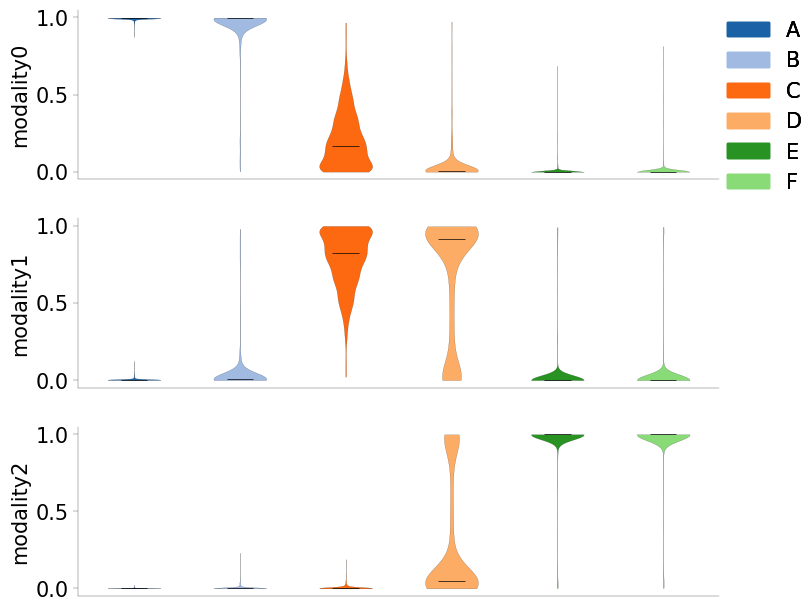

In [26]:
oci.pl.violin(adata, groups='type', values='weights', cdict=cdict, fontsize=15, 
              figsize=(8, 6))

`modality0` is dominant for types A and B, `modality1` for types C and D, and `modality2` for types E and F.

You can further visualize multimodal weights on scatter plots.

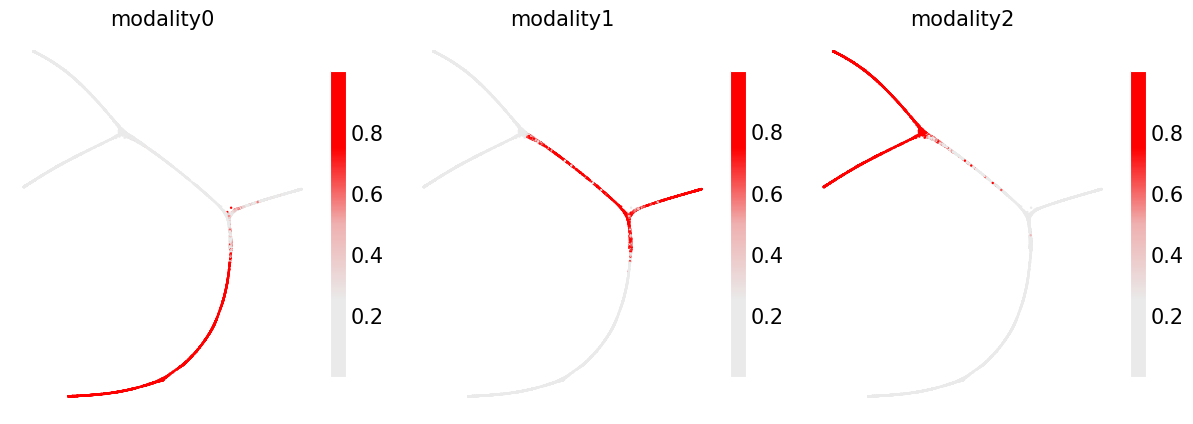

In [27]:
from matplotlib.colors import LinearSegmentedColormap
weights_cmap = LinearSegmentedColormap.from_list(
    'custom', ['#EAEAEA', '#EAEAEA', '#EFB0B0', '#FF0000', '#FF0000'], N=256)

oci.pl.scatter(adata, x='X_fa2', c='weights', cmap=weights_cmap,  markersize=3, 
               fontsize=15, figsize=(12, 5))

### The advantage of multiple modalities

Above, you investigated three modalities, each introducing a branching point starting two new lineages. Through multimodal analysis, you managed to create a joint representation capturing all developmental fates, inseparable by single modalities.

Now, you will further explore joint representations by limiting information fed to MDM. Run MDM on two modalities, e.g., ``modality0`` and ``modality1``. This way, you take away information about ``modality2``'s branching point and the separability of type E and F fates.

Change ``adata.uns['modalities']`` so that MDM is trained on ``modality0`` and ``modality1``.

In [28]:
adata.uns['modalities'] = ['modality0', 'modality1']

Calculate multimodal weights and MDM components.

In [29]:
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=10, unimodal_norm=False, verbose=True, random_state=SEED)

2023-01-22 23:24:51,921	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2023-01-22 23:24:57,501	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


Create the nearest neighbor graph in the MDM latent space and find its FLE representation.

In [30]:
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=30, verbose=True)
oci.tl.neighbors_graph(adata, x='X_mdm', n_edges=30, verbose=True)
oci.tl.FA2(adata, n_components=2, n_iter=5000, random_state=SEED)

[X_mdm]	30 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Jan 22, 2023 11:25:19 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 22, 2023 11:25:20 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 6,000 (6,000 added)
Jan 22, 2023 11:25:20 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 180,000 (107,431 added)


*************************25%
*************************50%
*************************75%
************************

*100%
Time = 30.383s


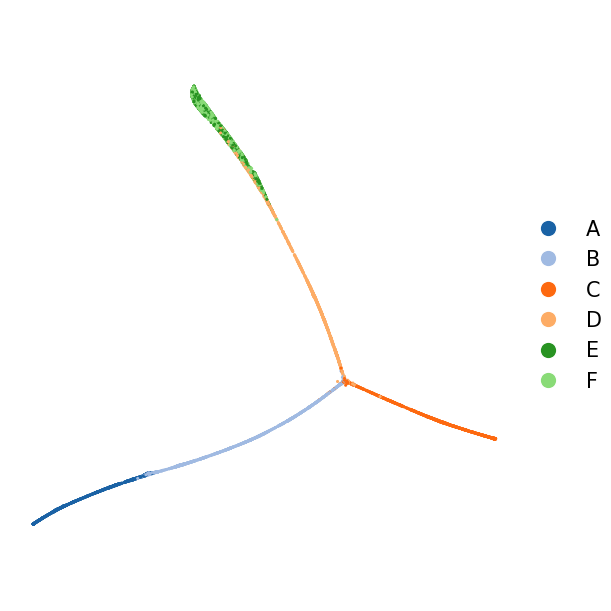

In [31]:
oci.pl.scatter(adata, x='X_fa2', c='type', cdict=cdict, markersize=5, markerscale=2, 
               fontsize=15, figsize=(6,6), title='')

As expected, developmental fates E and F from unused ``modality2`` are mixed, while types well-separated in ``modality0`` and ``modality1``are correctly reconstructed. Multimodal weight distribution shows why this happens.

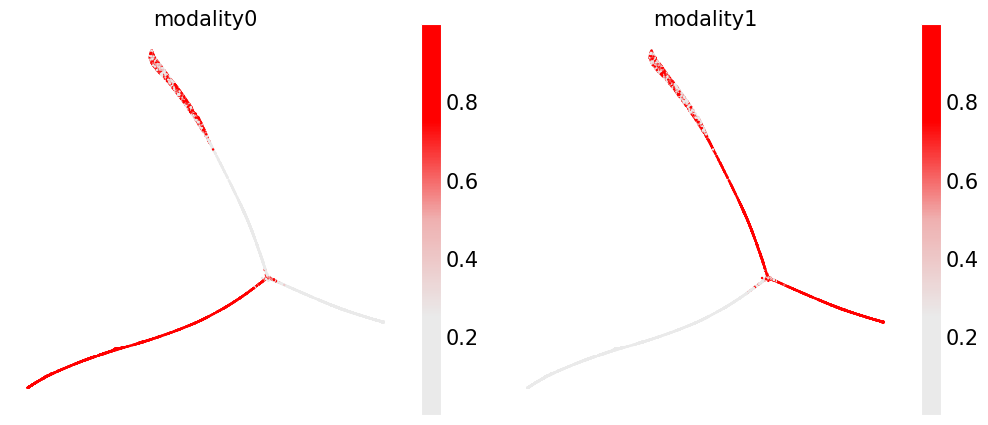

In [32]:
oci.pl.scatter(adata, x='X_fa2', c='weights', cmap=weights_cmap, markersize=3, 
               fontsize=15, figsize=(10, 6))

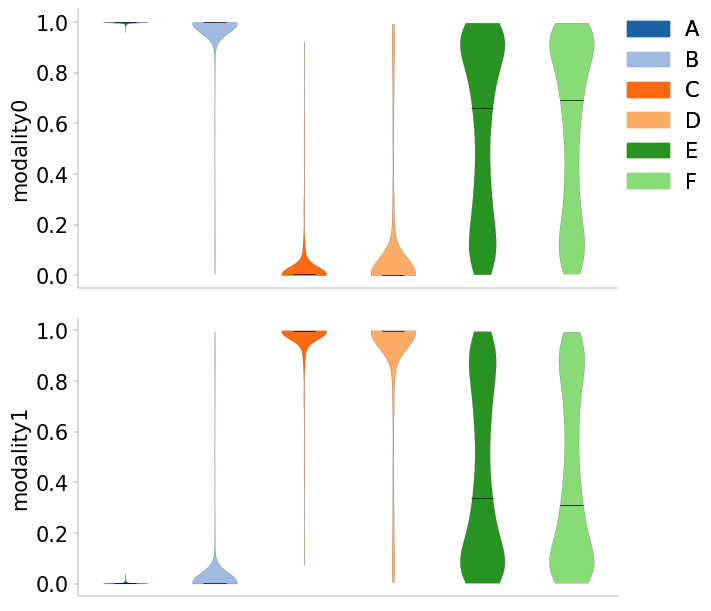

In [33]:
oci.pl.violin(adata, groups='type', values='weights', cdict=cdict, fontsize=15, 
              figsize=(7, 6))

## Simulated data II: Sparse connections

The second simulated dataset is bimodal and consists of 4,500 3-dimensional observations. You can download it [here](LINK).

In [34]:
source_path = '../../../data/simulated_data_ii'
adata = ad.read_h5ad(join(source_path, 'sparse-transitions-dataset.h5ad'))

adata

AnnData object with n_obs × n_vars = 4500 × 1
    obs: 'type', 'pseudotime'
    uns: 'modalities'
    obsm: 'modality0', 'modality1'

### Exploring single modalitites

Observations are assigned to nine types A-I (`adata.obs['type']`) and ordered along a developmental pseudotime (`adata.obs['pseudotime']`).

As for the previous dataset, start with visualizing single modalities.

In [35]:
cdict = {'A': '#cb111e',
         'B':  '#814eaf',
         'C':  '#fc8384', 
         'D':  '#1a62a5',
         'E': '#a0bae2',
         'F': '#fd6910',
         'G': '#fdac65',
         'H': '#289322',
         'I': '#89db77'}

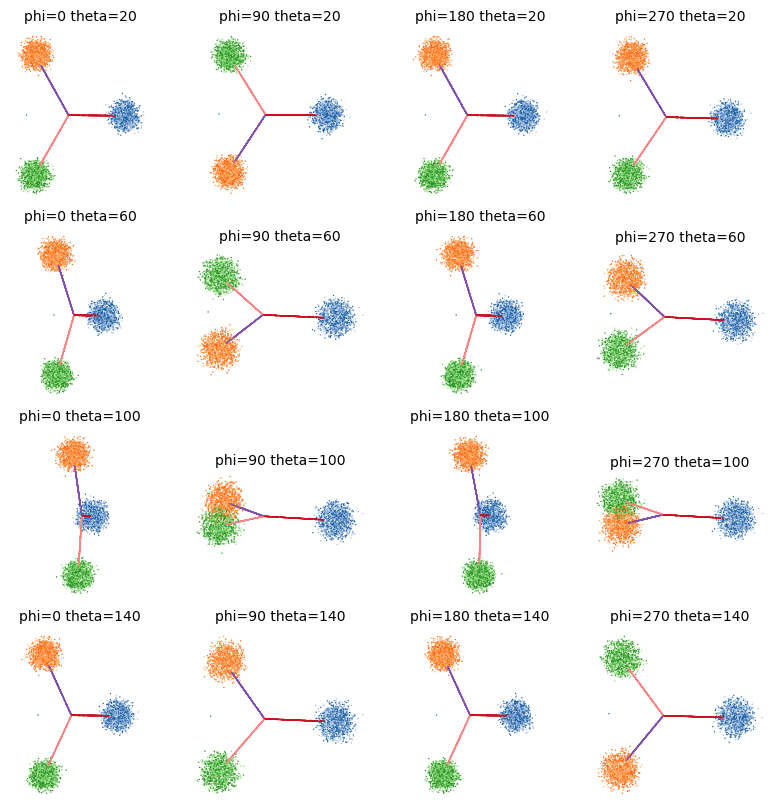

In [36]:
oci.pl.projections(adata, x='modality0', c='type', phis=[0, 90, 180, 270], 
                   thetas=[20, 60, 100, 140], cdict=cdict, markersize=1, fontsize=10, 
                   figsize=(8, 8), showlegend=False, random_state=SEED)

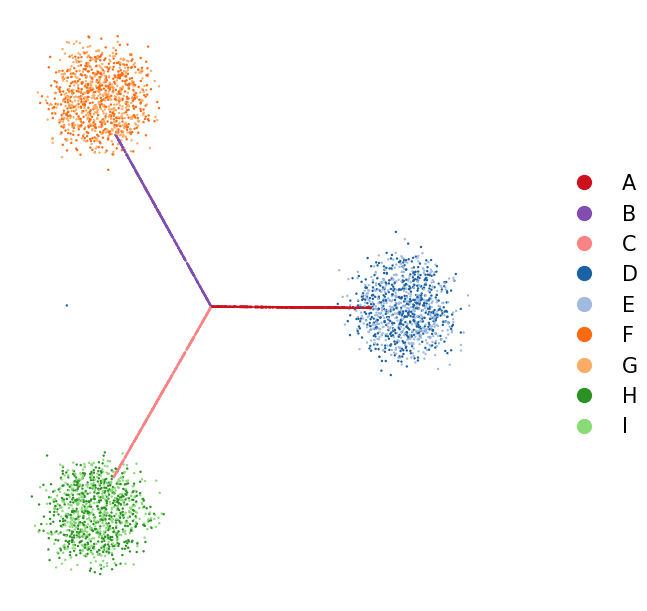

In [37]:
oci.tl.projection(adata, x='modality0', phi=0, theta=20, random_state=SEED)
oci.pl.scatter(adata, x='X_proj', c='type', cdict=cdict, markersize=3, markerscale=2, 
               fontsize=15, figsize=(7, 6), title='')

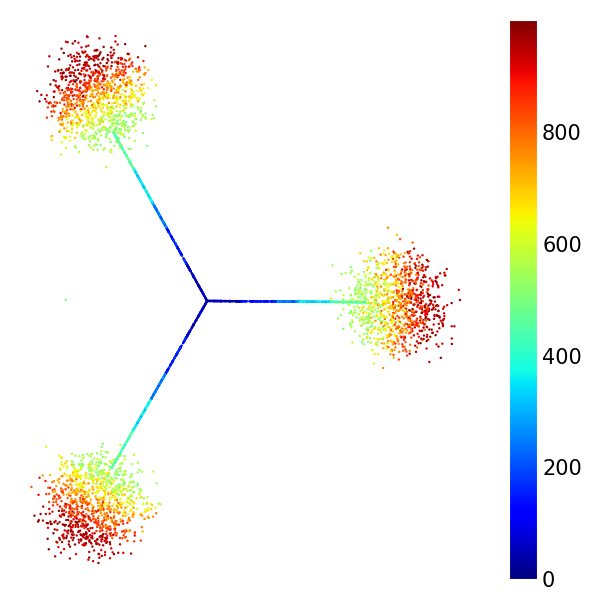

In [38]:
oci.pl.scatter(adata, x='X_proj', c='pseudotime', cmap='jet', markersize=3, 
               markerscale=2, fontsize=15, figsize=(7, 6), title='')

``modality0`` exposes types A-C as sparse transitions but cannot distinguish between fates D/E, F/G, and H/I, separated in `modality1`.

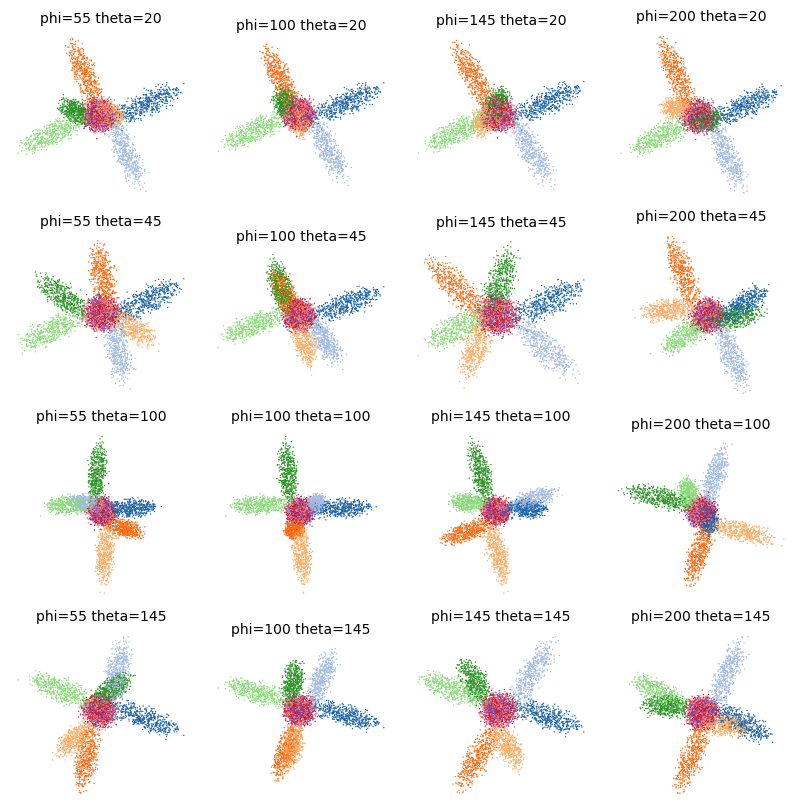

In [39]:
oci.pl.projections(adata, x='modality1', c='type', phis=[55, 100, 145, 200], 
                   thetas=[20, 45, 100, 145], cdict=cdict, markersize=1, fontsize=10, 
                   figsize=(8, 8), showlegend=False, random_state=SEED)

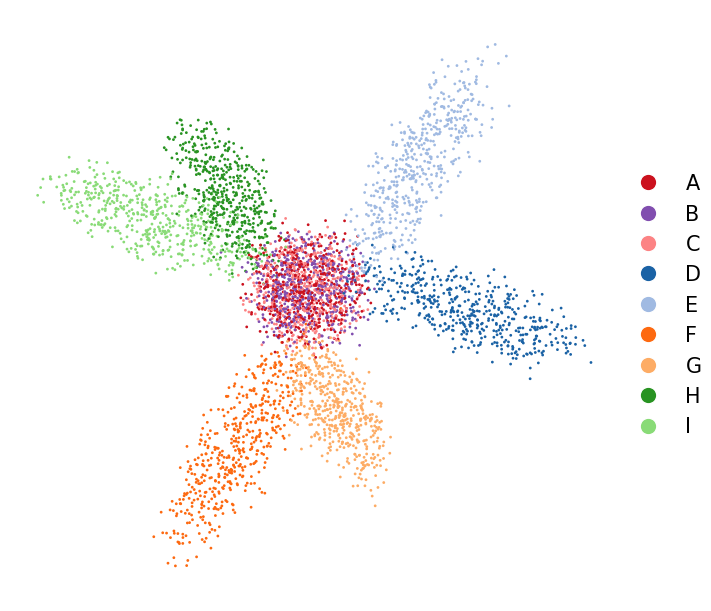

In [40]:
oci.tl.projection(adata, x='modality1', phi=145, theta=145, random_state=SEED)
oci.pl.scatter(adata, x='X_proj', c='type', cdict=cdict, markersize=4, markerscale=2, 
               fontsize=15, figsize=(7, 6), title='')

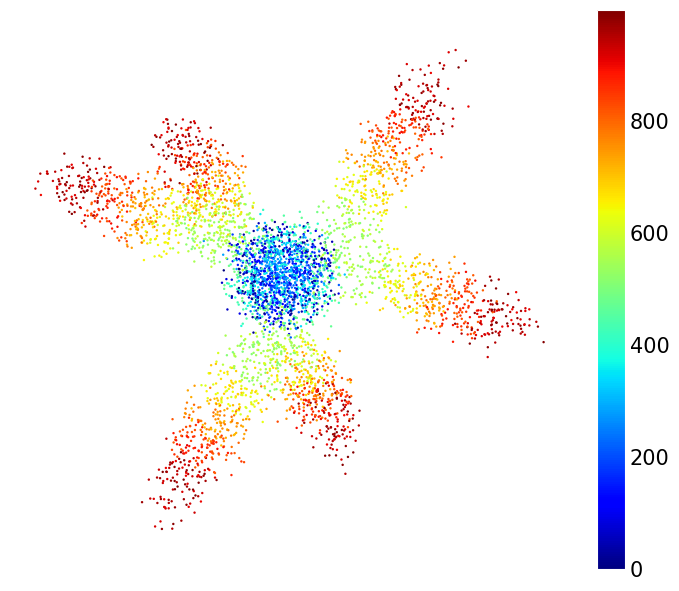

In [41]:
oci.pl.scatter(adata, x='X_proj', c='pseudotime', cmap='jet', markersize=3, 
               markerscale=2, fontsize=15, figsize=(7, 6), title='')

### Multimodal Diffusion Maps

Generate the MDM embedding: 1) calculate nearest neighbors, 2) multimodal weights, and 3) MDM components.

In [42]:
oci.pp.neighbors(adata, n_neighbors=60, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=20, unimodal_norm=False, random_state=SEED, verbose=True)

[modality0]	60 nearest neighbors calculated.
[modality1]	60 nearest neighbors calculated.


2023-01-22 23:25:58,230	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2023-01-22 23:26:04,894	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculated.


### Visualizing MDM components

Create an FLE representation based on the nearest neighbors graph.

In [43]:
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=60, verbose=True)
oci.tl.neighbors_graph(adata, x='X_mdm', n_edges=60, verbose=True)
oci.tl.FA2(adata, n_components=2, n_iter=5000, random_state=SEED)

[X_mdm]	60 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Jan 22, 2023 11:26:25 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 22, 2023 11:26:26 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 4,500 (4,500 added)
Jan 22, 2023 11:26:26 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 270,000 (152,392 added)


*************************25%
*************************50%
*************************75%
*************

************100%
Time = 33.959s


MDM managed to reconstruct developmental fates D-I and their origin A-C.

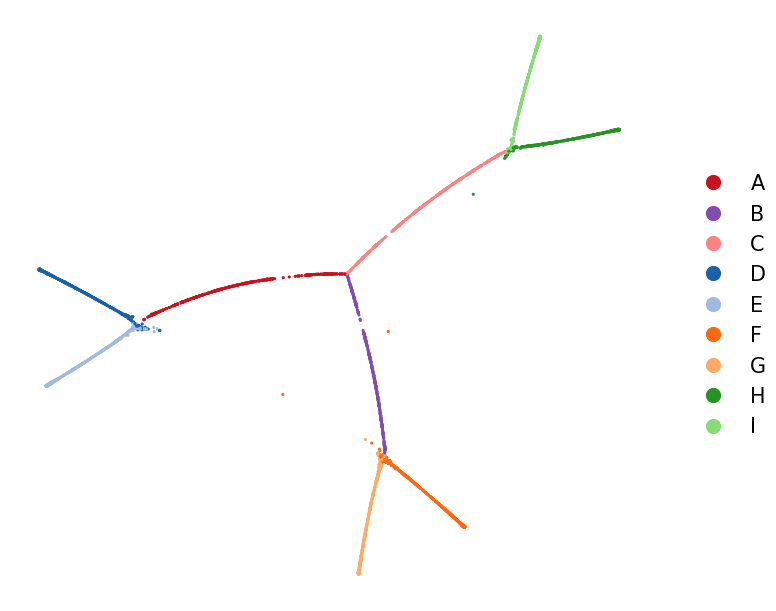

In [44]:
oci.pl.scatter(adata, x='X_fa2', c='type', cdict=cdict, markersize=5, markerscale=2, 
               fontsize=15, figsize=(8,6), title='')

Additionally, MDM preserved developmental pseudotime.

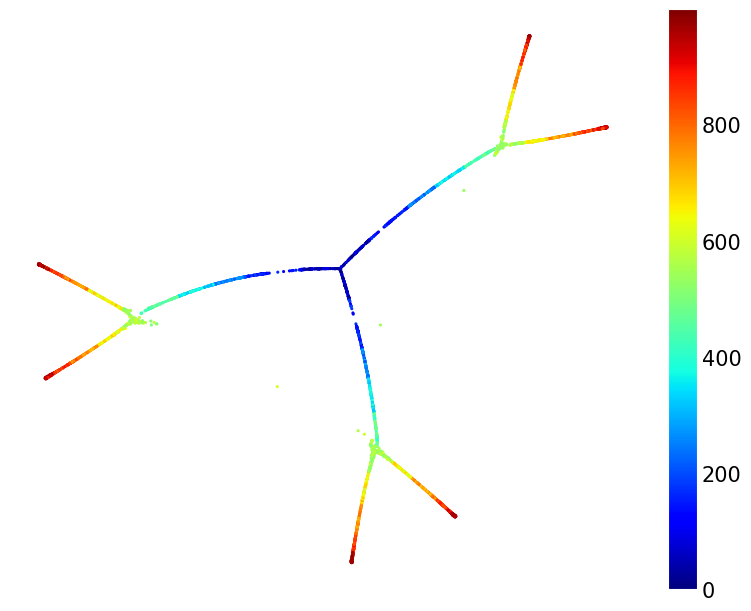

In [45]:
oci.pl.scatter(adata, x='X_fa2', c='pseudotime', cmap='jet', markersize=5, 
               markerscale=2, fontsize=15, figsize=(8,6), title='')

### Multimodal weights distribution

Multimodal weight distribution confirms that `modality0` is more informative about types A-C and `modality1` about types D-I.

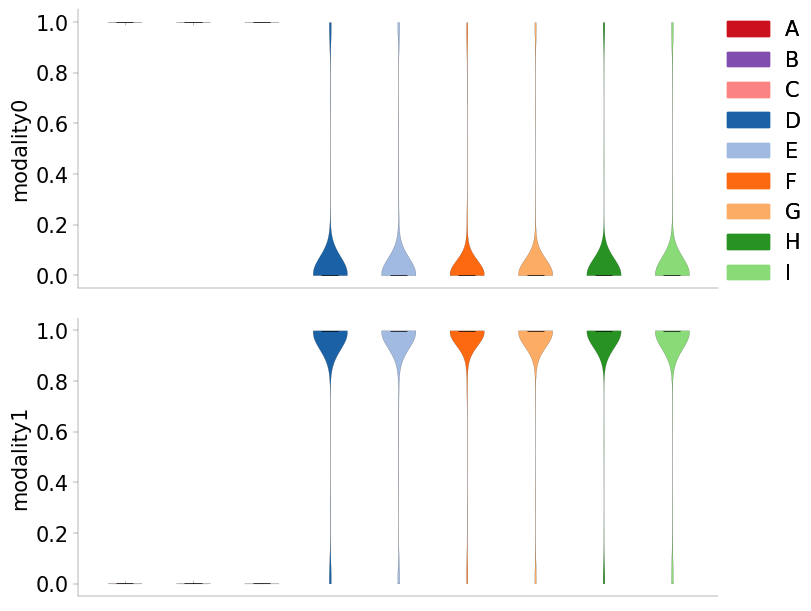

In [46]:
oci.pl.violin(adata, groups='type', values='weights', cdict=cdict, fontsize=15, 
              figsize=(8, 6))

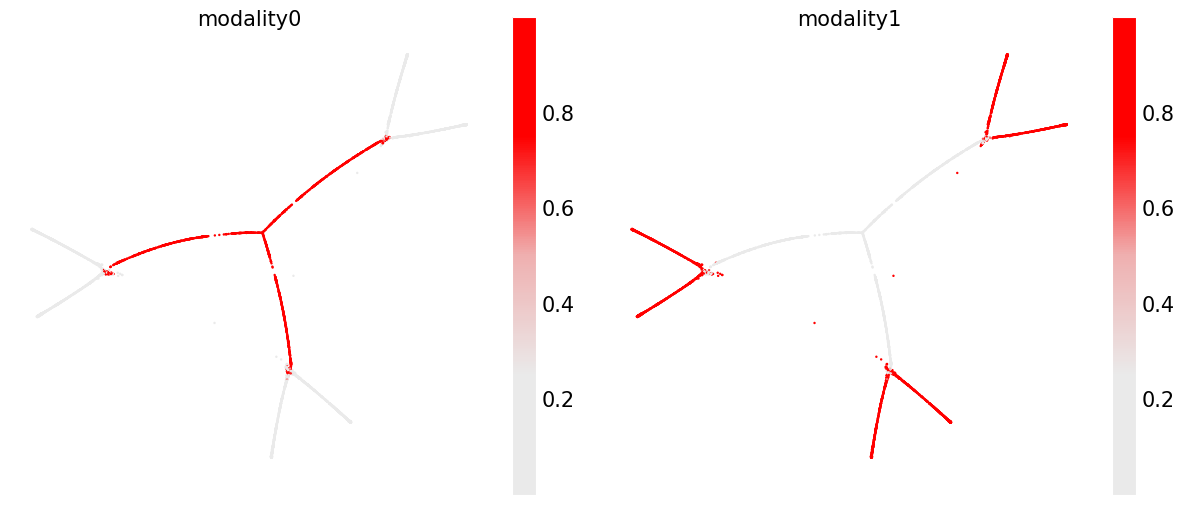

In [47]:
oci.pl.scatter(adata, x='X_fa2', c='weights', cmap=weights_cmap, markersize=3, 
               fontsize=15, figsize=(12, 5))

It is a wrap-up of the first tutorial. You should better understand why joint multimodal visualizations unlock a new comprehension of data and how to build a basic Ocelli workflow.

In the following chapters, we will focus on single-cell data analysis.